# Domestic Animals
We will attempt to train an image classification model that categorises domestic animals.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

### Download dataset from google
We make use of a library called `google_images_download`.

In [ ]:
# !pip install google_images_download

In [31]:
from google_images_download import google_images_download

response = google_images_download.googleimagesdownload()

In [3]:
names = ['Guinea Pig','Cat','Hamster','Fish','Tortoise','Rabbit','Dog','Ferret','Bird','Horse','Domestic Chicken','Goat','Pig','Duck']

In [4]:
len(names)

14

We space out the search for images since we can only get 100 images at once (otherwise we get a weird error).

In [32]:
dates = [2010,2012,2014,2016,2018,2019]

In [33]:
d = '{{"time_min":"01/01/{}","time_max":"01/01/{}"}}'.format(dates[0],dates[1])

In [34]:
args = {'time_range':d,'exact_size':"512,512",'keywords':'bird','limit':100,'format':'jpg','output_directory':'images','prefix':'test','silent_mode':True}

Use multiprocessing to speed things up a bit.

In [44]:
from multiprocessing import Pool

def f(n):
    ns = ('_').join(n.split())
    a = args.copy()
    a['keywords'] = n
    a['prefix'] = ns
    for i in range(len(dates)-1):
        d = '{{"time_min":"01/01/{}","time_max":"01/01/{}"}}'.format(dates[i],dates[i+1])
        a['time_range']=d
        print(f'#{i+1} iteration for {n}')
        p = response.download(a)
    print(f'Completed 5 steps for {n}')
    
if __name__ == '__main__':
    p = Pool(8)
    print(p.map(f, names))

#1 iteration for Guinea Pig
#1 iteration for Tortoise
#1 iteration for Rabbit
#1 iteration for Fish
#1 iteration for Cat
#1 iteration for Dog
#1 iteration for Hamster
#1 iteration for Ferret


Unfortunately all 100 could not be downloaded because some images were not downloadable. 83 is all we got for this search filter!
#2 iteration for Rabbit


Unfortunately all 100 could not be downloaded because some images were not downloadable. 86 is all we got for this search filter!
#2 iteration for Ferret


Unfortunately all 100 could not be downloaded because some images were not downloadable. 77 is all we got for this search filter!
#2 iteration for Dog


Unfortunately all 100 could not be downloaded because some images were not downloadable. 76 is all we got for this search filter!
#2 iteration for Fish


Unfortunately all 100 could not be downloaded because some images were not downloadable. 88 is all we got for this search filter!
#2 iteration for Hamster


Unfortunately all 100 could not

Process ForkPoolWorker-22:
Process ForkPoolWorker-18:
Process ForkPoolWorker-21:
Process ForkPoolWorker-24:
Process ForkPoolWorker-23:
Process ForkPoolWorker-17:
Process ForkPoolWorker-19:
Process ForkPoolWorker-20:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jupyter/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jupyter/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jupyter/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jupyter/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jupyter/anaconda3/lib/python3.7/mu

Check files for errors are remove them where appropriate.

In [45]:
##A function to recursively get all jpg files in a directory.

def setify(o): return o if isinstance(o,set) else set(listify(o))

def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

#export
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [69]:
path = Path('./images/')

In [70]:
#Obtain list of images we downloaded
res = get_files(path,extensions='.jpg',recurse=True)

In [71]:
len(res)

6053

In [72]:
from PIL import Image

count=0
for r in res:
    try:
        im = Image.open(r)
        im.verify()
    except:
        os.remove(r)
        count+=1
print(f'Removed {count} files.')

Removed 0 files.


In [73]:
res = get_files(path,extensions='.jpg',recurse=True)
print(len(res))

6053


### Datablock API

In [5]:
path = Path('./')

In [6]:
src = (ImageList.from_folder(path,extensions='.jpg',recurse=True,include='images')
        .split_by_rand_pct()
        .label_from_func(lambda x: x.parent.name))

In [7]:
data = (src
        .transform(get_transforms(),size=(256,256))        
        .databunch(bs=50)
        .normalize(imagenet_stats))

In [6]:
print(data.classes)
print(data.c)

['Bird', 'Cat', 'Chicken', 'Dog', 'Duck', 'Ferret', 'Fish', 'Goat', 'Guinea Pig', 'Hamster', 'Horse', 'Pig', 'Rabbit', 'Tortoise']
14


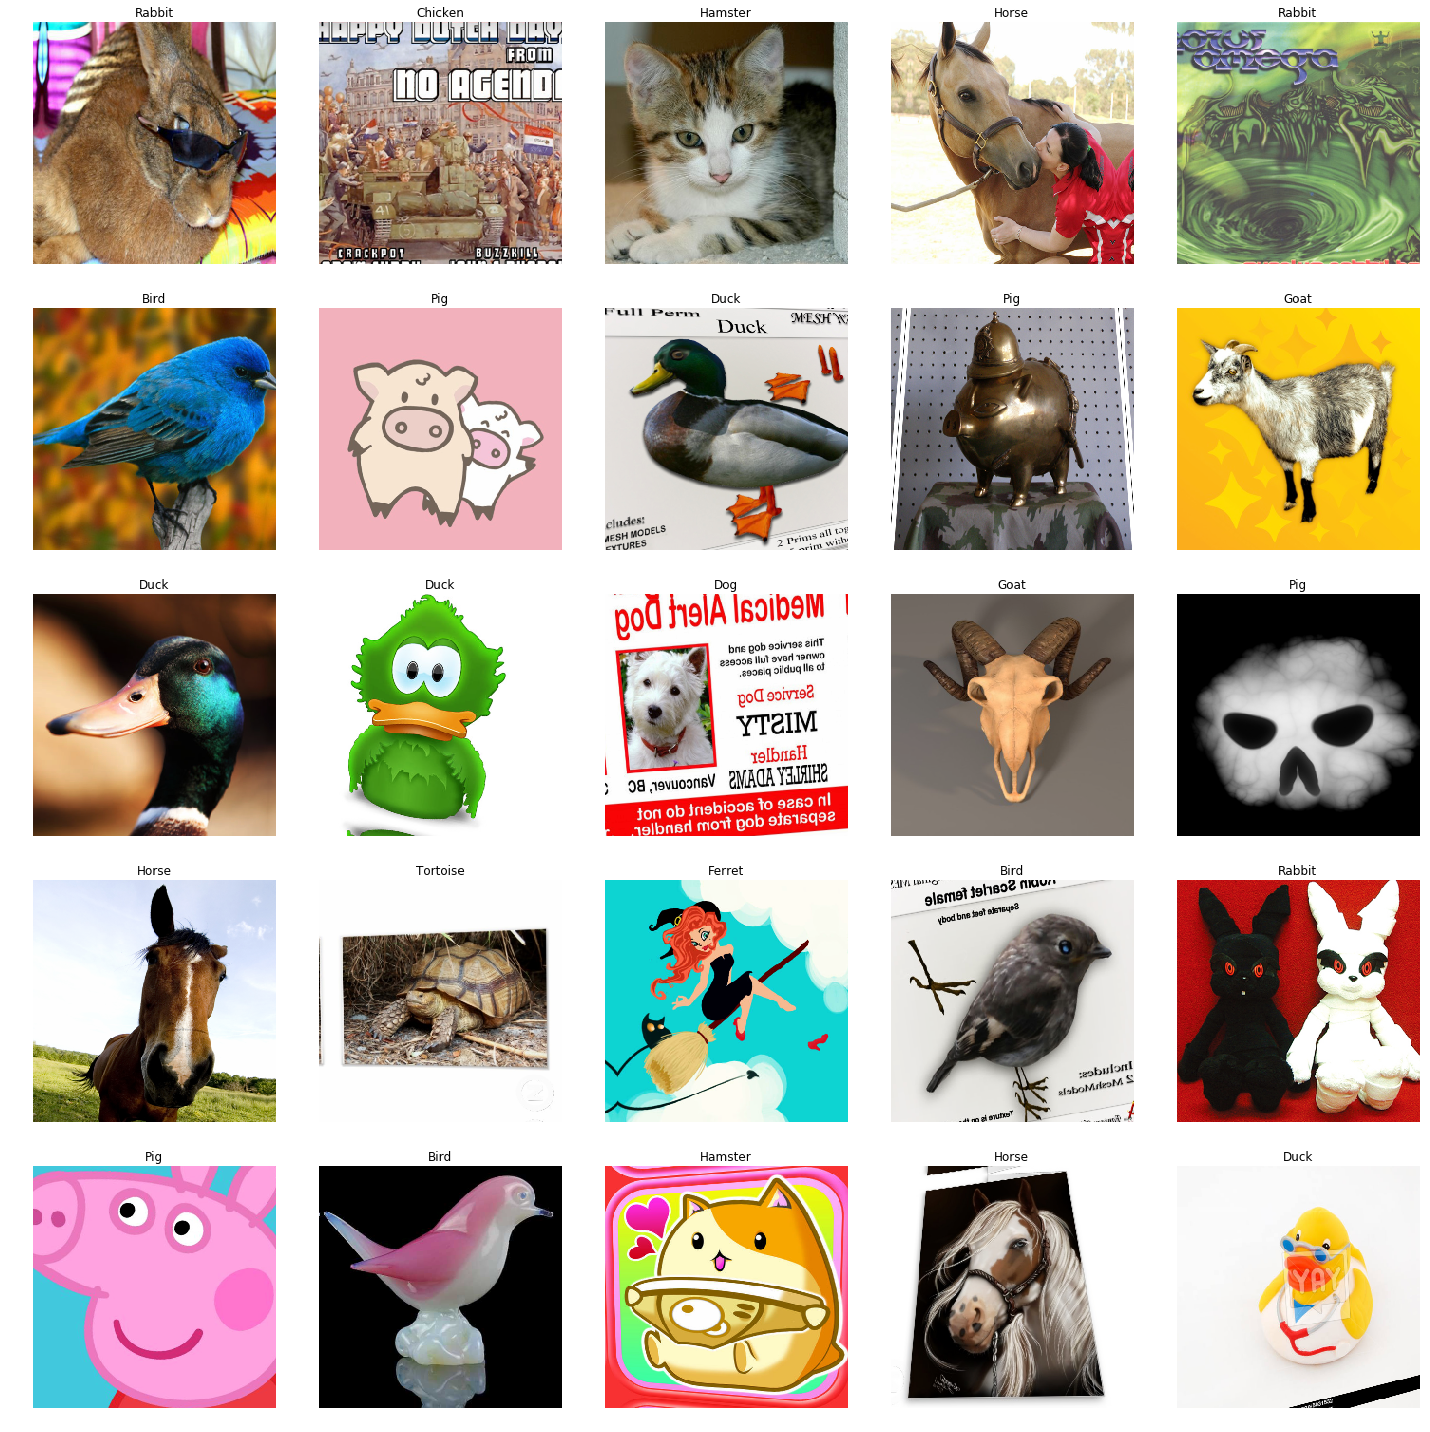

In [78]:
data.show_batch()

### Begin training model 
We use the resnet-50 model.

In [8]:
defaults.device = torch.device('cuda')
learn2 = cnn_learner(data, models.resnet50, metrics=error_rate)

We use label smoothing for better results.

In [9]:
learn2.loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1)

In [24]:
lr_find(learn2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [25]:
learn2.recorder.plot??

Min numerical gradient: 3.02E-03
Min loss divided by 10: 6.92E-03


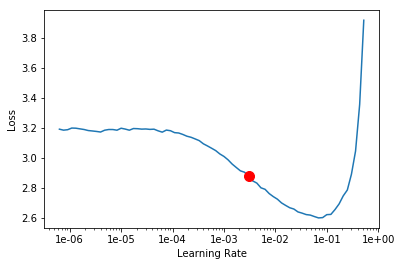

In [26]:
learn2.recorder.plot(suggestion=True)

In [ ]:
learn2.freeze()
learn2.fit_one_cycle(10,1e-2)

In [ ]:
learn2.save('1-small-50')

In [ ]:
learn2.load('1-small-50')

In [ ]:
learn2.unfreeze()

In [23]:
learn2.fit_one_cycle(10, slice(3e-5,1e-3))

In [ ]:
learn2.save('2-small-50')

In [ ]:
learn2.load('2-small-50')

In [8]:
learn2.fit_one_cycle(10, slice(3e-6,3e-4))

In [ ]:
learn2.save('final-small-50')

In [ ]:
learn2.load('final-small-50')

In [9]:
interp = ClassificationInterpretation.from_learner(learn2,ds_type=DatasetType.Valid)

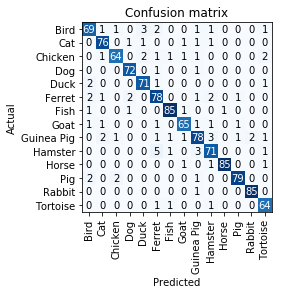

In [10]:
interp.plot_confusion_matrix()

In [11]:
interp.probs = torch.softmax(interp.probs,dim=-1)

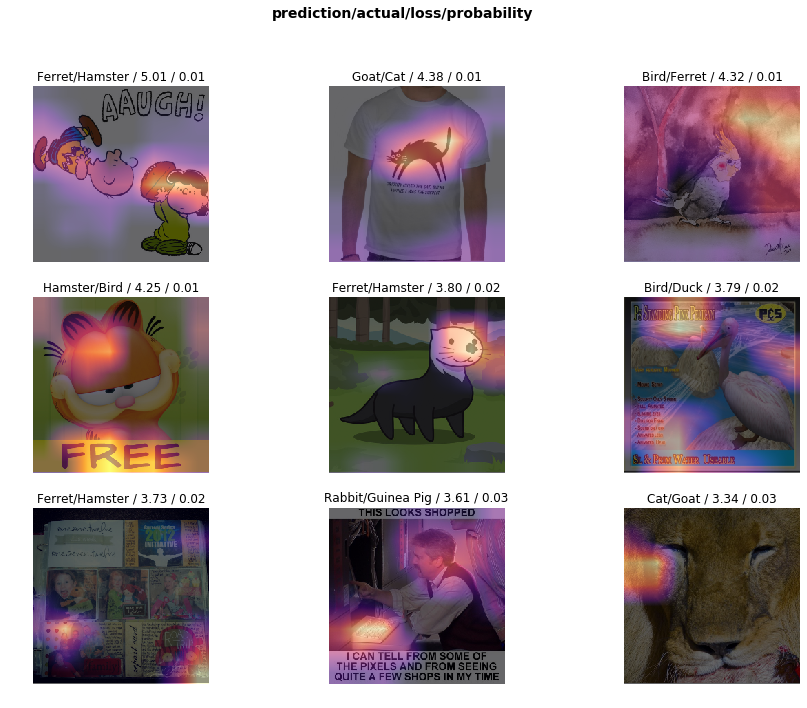

In [12]:
interp.plot_top_losses(9, figsize=(15,11))

In [13]:
interp.most_confused(min_val=2)

[('Hamster', 'Ferret', 5),
 ('Bird', 'Duck', 3),
 ('Guinea Pig', 'Hamster', 3),
 ('Hamster', 'Guinea Pig', 3),
 ('Bird', 'Ferret', 2),
 ('Chicken', 'Duck', 2),
 ('Chicken', 'Tortoise', 2),
 ('Duck', 'Bird', 2),
 ('Ferret', 'Bird', 2),
 ('Ferret', 'Dog', 2),
 ('Ferret', 'Hamster', 2),
 ('Guinea Pig', 'Cat', 2),
 ('Guinea Pig', 'Rabbit', 2),
 ('Pig', 'Bird', 2),
 ('Pig', 'Chicken', 2)]

### Export our model
We can use deploy it to a webapp later for inference.

In [14]:
learn2.export()

### What turns our model on?
We inspect the activations (and gradients) of our model to see which parts of it get activated during inference.

In [20]:
#We download an image of a rooster
!wget https://media.gettyimages.com/photos/rooster-walking-aroun-key-west-picture-id157439916?s=612x612 -O {path}/sample/rooster.jpg

--2019-05-19 08:45:39--  https://media.gettyimages.com/photos/rooster-walking-aroun-key-west-picture-id157439916?s=612x612
Resolving media.gettyimages.com (media.gettyimages.com)... 99.84.194.10, 99.84.194.100, 99.84.194.17, ...
Connecting to media.gettyimages.com (media.gettyimages.com)|99.84.194.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76673 (75K) [image/jpeg]
Saving to: ‘./sample/rooster.jpg’

./sample/rooster.jp 100%[===================>]  74.88K  --.-KB/s    in 0s      

2019-05-19 08:45:39 (169 MB/s) - ‘./sample/rooster.jpg’ saved [76673/76673]



In [26]:
#torch.device('cuda')
defaults.device = torch.device('cpu')

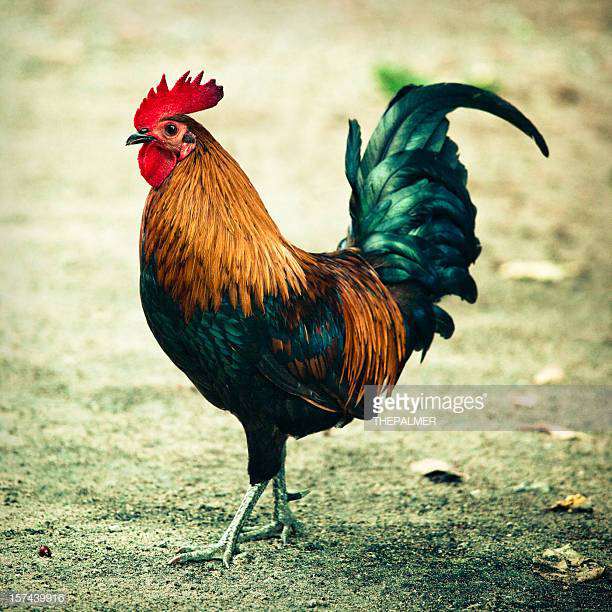

In [11]:
img = open_image(path/'sample'/'rooster.jpg')
img

In [28]:
learn = load_learner(path)

In [29]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category Chicken

We have confirmed that the model thinks this is a chicken, now let's see what turns it on.

In [44]:
defaults.device = torch.device('cuda')

In [20]:
xb,_ = data.one_item(img)

In [24]:
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [25]:
from fastai.callbacks.hooks import *

In [32]:
m = learn2.model.eval();

In [33]:
def hooked_backward(cat):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [45]:
print(data.classes)

['Bird', 'Cat', 'Chicken', 'Dog', 'Duck', 'Ferret', 'Fish', 'Goat', 'Guinea Pig', 'Hamster', 'Horse', 'Pig', 'Rabbit', 'Tortoise']


In [34]:
#Chicken is the 2nd class in the list above
hook_a,hook_g = hooked_backward(2)

In [35]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([2048, 8, 8])

We just want the average activation of each position on the 8x8 grid.

In [36]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([8, 8])

In [39]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,256,256,0),
              interpolation='bilinear', cmap='magma');

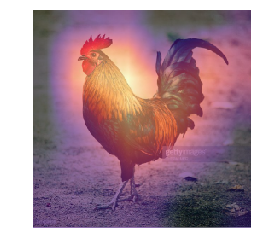

In [40]:
show_heatmap(avg_acts)

Looks like the rooster's head and its upper body is responsible for most of the activations.

### Gradient-weighted Class Activation Mapping (Grad-CAM)
For even better results, we use the idea from this paper where we take a weighted average of the activations in each position weighted by the average gradient of each channel.

In [46]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([2048, 8, 8]), torch.Size([2048]))

In [47]:
mult = (acts*grad_chan[...,None,None]).mean(0)

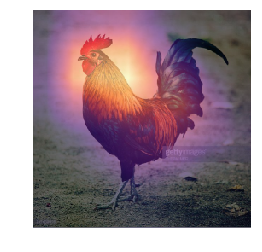

In [48]:
show_heatmap(mult)

Here we can more clearly identify the rooster's head as the dead giveaway that it's a chicken.